In [1]:
# pip install numexpr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from math import sqrt
import numexpr
import itertools
import warnings
color_pal = sns.color_palette()
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg


# 1: Biggest predictor of CO2 output
# To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.
# Your answer can also be a specific combination of certain factors.

# Hiervoor geaggregeerde data nodig wereld totaal, dus ook voor afhankelijke variabelen.
gdp = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/co2-emissions-vs-gdp.csv")

gdp = gdp.loc[(gdp['Entity']=="World") & (gdp['Year'] >= 1960), ['Year', 'Annual CO₂ emissions (per capita)', 'GDP per capita']]
gdp.rename(columns= {'Annual CO₂ emissions (per capita)': 'CO₂ emissions per capita'}, inplace=True)  # 'Year': 'year',
gdp = gdp.reset_index(drop=True)

gdp['Year'] =  pd.to_datetime(gdp['Year'], format='%Y')
gdp = gdp.reset_index().set_index('Year').to_period('Y')
gdp.drop(columns=['index'], inplace=True)

gdp_abs = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/world-gdp-over-the-last-two-millennia.csv")

gdp_abs.rename(columns= {'World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))': 'GDP'}, inplace=True)
gdp_abs = gdp_abs.loc[(gdp_abs['Year'] >= 1960), ['Year', 'GDP']]
gdp_abs['Year'] =  pd.to_datetime(gdp_abs['Year'], format='%Y')
gdp_abs = gdp_abs.reset_index().set_index('Year').to_period('Y')
gdp_abs.drop(columns=['index'], inplace=True)

population = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/population-and-demography.csv", usecols=[0, 1, 2])
population = population.loc[(population['Country name']=="World") & (population['Year'] >= 1960), ['Year', 'Population']]
population['Year'] =  pd.to_datetime(population['Year'], format='%Y')
population = population.reset_index().set_index('Year').to_period('Y')
population.drop(columns=['index'], inplace=True)

electr_access = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/Access-to-electricity.csv",header=0,
                         skiprows=lambda x: x not in [0, 260], usecols=lambda x: x not in ['Unnamed: 67']) #,names=range(68)

energy_use = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/Energy-use.csv",header=0,
                         skiprows=lambda x: x not in [4, 264], usecols=lambda x: x not in ['Unnamed: 67'])
pop_growth = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/Population-growth.csv",header=0,
                         skiprows=lambda x: x not in [4, 264], usecols=lambda x: x not in ['Unnamed: 67'])
urb_pop_growth = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/Urban-population-growth.csv",header=0,
                             skiprows=lambda x: x not in [4, 264], usecols=lambda x: x not in ['Unnamed: 67'])
ren_energy_cons = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/Renewable-energy-consumption.csv",header=0,
                              skiprows=lambda x: x not in [4, 264], usecols=lambda x: x not in ['Unnamed: 67'])

df = pd.concat([energy_use, electr_access, pop_growth, urb_pop_growth, ren_energy_cons]).T
df.drop(['Country Name','Country Code','Indicator Code'], inplace=True)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df.reset_index(drop=False, inplace=True)

df.rename(columns= {'index': 'Year',
                    'Energy use (kg of oil equivalent per capita)': 'Energy use',
                    'Access to electricity (% of population)': 'Access to electricity',
                    'Population growth (annual %)': 'Population growth',
                    'Urban population growth (annual %)': 'Urban population',
                    'Renewable energy consumption (% of total final energy consumption)': 'Renew. energy consumption'}, inplace=True)

# vult een mean geen wezelijk verschil bij xgboost met train/test gap op 2008
# df['Energy use'].fillna(method='ffill', inplace=True)

df.rename_axis('', axis='columns', inplace=True)
df['Year'] =  pd.to_datetime(df['Year'], format='%Y')
df = df.reset_index().set_index('Year').to_period('Y')
df.drop(columns=['index'], inplace=True)

internet_use = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/Number-of-internet-users.csv",header=0,
                              skiprows=lambda x: x not in [0, *list(range(6286, 6317, 1))])
internet_use.drop(columns=['Entity', 'Code'], inplace=True)
internet_use['Year'] =  pd.to_datetime(internet_use['Year'], format='%Y')
internet_use = internet_use.reset_index().set_index('Year').to_period('Y')
internet_use.drop(columns=['index'], inplace=True)
internet_use.rename(columns= {'Number of Internet users': 'Number of internet users'}, inplace=True)

df1 = df.join(gdp, on='Year', how='left')
df2 = df1.join(population, on='Year', how='left')
df3 = df2.join(gdp_abs, on='Year', how='left')
features = df3.join(internet_use, on='Year', how='left')
features['GDP_calc'] = features['GDP per capita'] * features['Population']

features.loc[(features.index >= '2016') & (features.index <= '2018'), 'GDP'] = features.loc[(features.index >= '2016') & (features.index <= '2018'), 'GDP_calc']
features['GDP per capita'] = features['GDP'] / features['Population']
features.drop(columns=['GDP', 'Population', 'GDP_calc'], inplace=True)
features = features.copy()
features = features[features['CO₂ emissions per capita'].notnull()]
features = features.copy()
features.dropna(thresh=3)


,Energy use,Access to electricity,Population growth,Urban population,Renew. energy consumption,CO₂ emissions per capita,GDP per capita,Number of internet users
Year,,,,,,,,
1961,NaN,NaN,1.350748,2.819558,NaN,3.069531,4930.155604,NaN
1962,NaN,NaN,1.771495,3.059504,NaN,3.118656,5066.185478,NaN
1963,NaN,NaN,2.129277,3.244001,NaN,3.214131,5172.079216,NaN
1964,NaN,NaN,2.098466,3.222081,NaN,3.314634,5425.856982,NaN
1965,NaN,NaN,2.078464,2.707263,NaN,3.391434,5590.348698,NaN
...,...,...,...,...,...,...,...,...
2017,NaN,89.019548,1.148719,1.992037,17.919192,4.749682,14944.094000,3.483746e+09
2018,NaN,89.893733,1.10258,1.929135,18.162225,4.792753,15212.415000,3.795522e+09
2019,NaN,90.194716,1.055964,1.864506,18.636542,4.775633,NaN,4.194082e+09


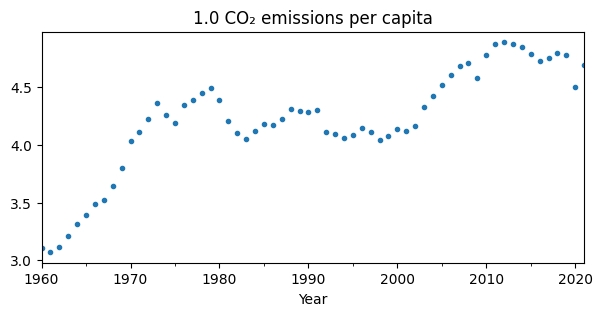

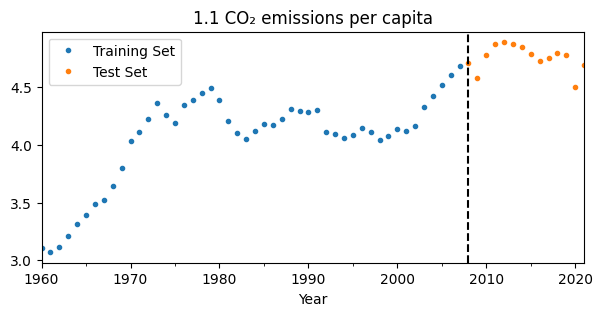

In [2]:
features['CO₂ emissions per capita'].plot(style='.',  #style standaard is line
        figsize=(7, 3),
        color=sns.color_palette()[0],
        title='1.0 CO₂ emissions per capita')
plt.show()

train = features.loc[features.index < '2008']
test = features.loc[features.index >= '2008']

fig, ax = plt.subplots(figsize=(7, 3))
train['CO₂ emissions per capita'].plot(ax=ax, label='Training Set', title='1.1 CO₂ emissions per capita', style='.')
test['CO₂ emissions per capita'].plot(ax=ax, label='Test Set', style='.')
ax.axvline('2008', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [3]:
FEATURES = ['Energy use', 'Access to electricity', 'Population growth', 'Urban population', 'Renew. energy consumption', 'GDP per capita', 'Number of internet users']
TARGET = 'CO₂ emissions per capita'

x_train = train[FEATURES].astype('float')
y_train = train[TARGET].astype('float')

x_test = test[FEATURES].astype('float')
y_test = test[TARGET].astype('float')

In [4]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1110,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:3.54634	validation_1-rmse:4.22153
[100]	validation_0-rmse:1.35046	validation_1-rmse:1.93028
[200]	validation_0-rmse:0.52773	validation_1-rmse:1.10863
[300]	validation_0-rmse:0.21852	validation_1-rmse:0.77501
[400]	validation_0-rmse:0.09831	validation_1-rmse:0.65568
[500]	validation_0-rmse:0.04981	validation_1-rmse:0.59618
[600]	validation_0-rmse:0.02903	validation_1-rmse:0.57176
[700]	validation_0-rmse:0.01996	validation_1-rmse:0.55875
[800]	validation_0-rmse:0.01504	validation_1-rmse:0.55539
[900]	validation_0-rmse:0.01180	validation_1-rmse:0.55429
[1000]	validation_0-rmse:0.00947	validation_1-rmse:0.55245
[1100]	validation_0-rmse:0.00796	validation_1-rmse:0.55240
[1109]	validation_0-rmse:0.00784	validation_1-rmse:0.55244


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1110, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

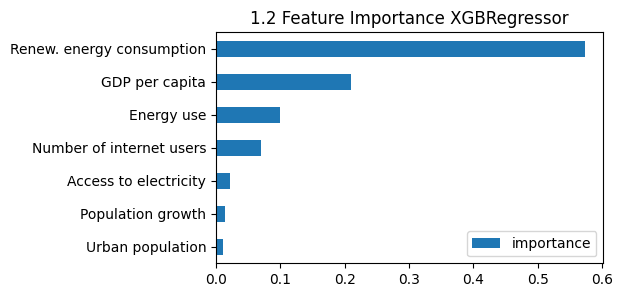

In [5]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(5, 3), title='1.2 Feature Importance XGBRegressor')
plt.show()

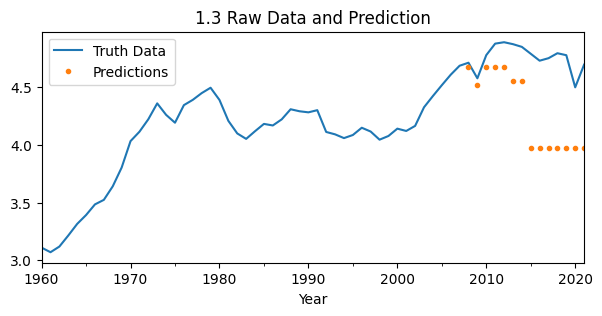

In [6]:
test = test.copy()
test['prediction'] = reg.predict(x_test)
df = features.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = features['CO₂ emissions per capita'].plot(figsize=(7, 3))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('1.3 Raw Data and Prediction')
plt.show()

In [7]:
# knn
features_knn = features.copy()
features_knn.drop(columns='Access to electricity', inplace=True)
features_knn.dropna(inplace=True)
# display(features_knn)

# imputer = KNNImputer(n_neighbors=3, weights="uniform")
# # features = imputer.fit_transform(features)
# features = pd.DataFrame(imputer.fit_transform(features),columns = features.columns, index=features.index)
# display(features)

train = features_knn.loc[features_knn.index < '2012']
test = features_knn.loc[features_knn.index >= '2012']

FEATURES = ['Energy use', 'Population growth', 'Urban population', 'Renew. energy consumption', 'GDP per capita', 'Number of internet users']
x_train = train[FEATURES].astype('float')
y_train = train[TARGET].astype('float')

x_test = test[FEATURES].astype('float')
y_test = test[TARGET].astype('float')

In [8]:
# knn regressie
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [9]:
train_preds = knn_model.predict(x_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
display(rmse)

test_preds = knn_model.predict(x_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
display(rmse)

0.05110420494030805

0.12752907640298655

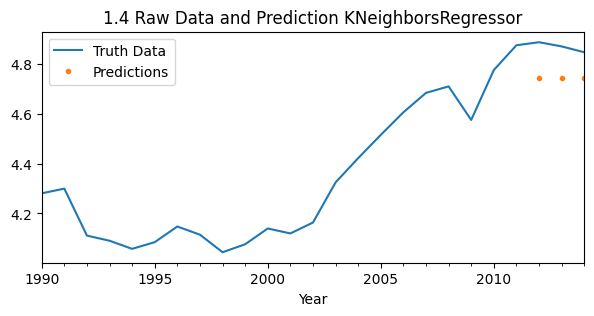

In [10]:
test = test.copy()
test['prediction'] = knn_model.predict(x_test)
df = features_knn.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = features_knn['CO₂ emissions per capita'].plot(figsize=(7, 3))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('1.4 Raw Data and Prediction KNeighborsRegressor')
plt.show()

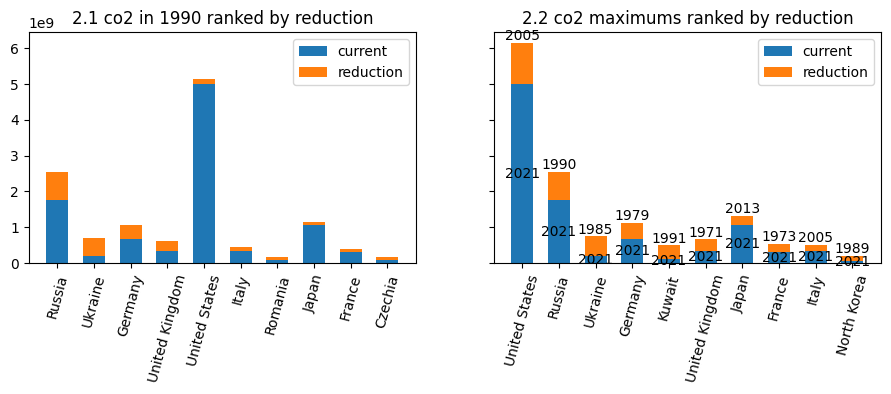

In [11]:
# 2: Biggest strides in decreasing CO2 output

co2 = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/annual-co2-emissions-per-country.csv", skipinitialspace=True)

co2 = co2.copy()
co2 = co2.loc[co2['Code'].astype('str') != 'nan', ['Entity', 'Year', 'Annual CO₂ emissions']]
co2 = co2.copy()
co2 = co2.loc[~co2['Entity'].astype('str').isin(['Antarctica', 'World']) , ['Entity', 'Year', 'Annual CO₂ emissions']]

co2.rename(columns= {'Entity': 'Country'}, inplace=True)
co2 = co2.copy()
co2 = co2.loc[co2['Year'] >= 1960]

cols = ['Year','Annual CO₂ emissions']
co2_dict = co2.groupby('Country').apply(lambda f: f[cols].values.tolist()).to_dict()  # .reset_index() # f[col].values for col in cols]
co2_dict_max = dict()
co2_dict_ninezero = dict()

warnings.filterwarnings("ignore", category=RuntimeWarning)
def divide(a, b):
  return (1 - a / b) * 100
vectorized_divide = np.vectorize(divide) # otypes=[float]

for key, value in co2_dict.items():
  co2_dict[key] = pd.DataFrame(data=np.array(value),
                               columns=[co2.columns[1], co2.columns[2]],
                               index=range(len(value)))
  co2_dict[key]['Year'] = pd.to_datetime(co2_dict[key]['Year'].astype('int'), format='%Y')
  co2_dict[key] = co2_dict[key].reset_index().set_index('Year').to_period('Y')
  co2_dict[key].drop(columns=['index'], inplace=True)

  co2_dict[key]['CO₂ % of max.'] = vectorized_divide(co2_dict[key]['Annual CO₂ emissions'], co2_dict[key]['Annual CO₂ emissions'].max())

  laatste_perc = co2_dict[key]['CO₂ % of max.'][co2_dict[key].index[-1]]
  max = co2_dict[key]['Annual CO₂ emissions'].max()
  max_index = co2_dict[key].idxmax()['Annual CO₂ emissions']
  co2_recent = co2_dict[key].loc[co2_dict[key].index[-1], 'Annual CO₂ emissions']

  co2_dict_max[key] = [round(max),
                      max_index,
                      co2_recent,
                      round(laatste_perc, 2),
                      round(laatste_perc/100 * max),
                      co2_dict[key].index[-1].year]

  ninezero_output = co2_dict[key].loc[co2_dict[key].index.astype(str) =='1990', 'Annual CO₂ emissions']

  if not ninezero_output.empty:
    try:
      co2_dict[key]['CO₂ % of 1990'] = vectorized_divide(co2_dict[key]['Annual CO₂ emissions'], ninezero_output)

      laatste_perc_ninezero_co2 = co2_dict[key]['CO₂ % of 1990'][co2_dict[key].index[-1]]
      ninezero_co2 = co2_dict[key].loc['1990', 'Annual CO₂ emissions']

      co2_dict_ninezero[key] = [round(ninezero_co2),
                                co2_recent,
                                round(laatste_perc_ninezero_co2, 2),
                                round(laatste_perc_ninezero_co2/100 * ninezero_co2),
                                co2_dict[key].index[-1].year]
    except ZeroDivisionError:
      continue

co2_dict_ninezero_reductie = dict(sorted(co2_dict_ninezero.items(), reverse=True, key=lambda item: item[1][3]))
co2_dict_ninezero_reductie_top_10 = dict(itertools.islice(co2_dict_ninezero_reductie.items(), 10))

ninezero_df = pd.DataFrame.from_dict(data=co2_dict_ninezero_reductie_top_10,
                                 columns=['1990', 'most recent', 'decrease %', 'decrease abs', 'decrease in'],
                                 orient='index')

co2_dict_max_sort_max_reductie = dict(sorted(co2_dict_max.items(), reverse=True, key=lambda item: item[1][4]))
co2_dict_max_sort_max_reductie_top_10 = dict(itertools.islice(co2_dict_max_sort_max_reductie.items(), 10))

max_df = pd.DataFrame.from_dict(data=co2_dict_max_sort_max_reductie_top_10,
                                 columns=['max', 'max in', 'most recent', 'decrease %', 'decrease abs', 'decrease in'],
                                 orient='index')

x = ((*ninezero_df.index.values.astype('str').tolist(),), (*max_df.index.values.astype('str').tolist(),),)

weight_counts = [
 {
    "current": ninezero_df['most recent'],  # labels duidelijker maken en op bars aangeven
    "reduction": ninezero_df['decrease abs'],
},
{
    "current": max_df['most recent'],
    "reduction": max_df['decrease abs'],
},
]
width = 0.6

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(11, 3))
bottom = np.zeros(10)

for boolean, weight_count in weight_counts[0].items():
    p = axes[0].bar(x[0], weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

bottom = np.zeros(10)
labels_years = [max_df['decrease in'].astype('str').tolist(), max_df['max in'].astype('str').tolist()]
label_types = ['center', 'edge']
i = 0

for boolean, weight_count in weight_counts[1].items():
    p = axes[1].bar(x[1], weight_count, width, label=boolean, bottom=bottom)
    axes[1].bar_label(p, labels=labels_years[i], label_type=label_types[i])
    i += 1

    bottom += weight_count

axes[0].set_title('2.1 co2 in 1990 ranked by reduction')
axes[1].set_title('2.2 co2 maximums ranked by reduction')


for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=75)
    ax.legend(loc="upper right")

plt.show()

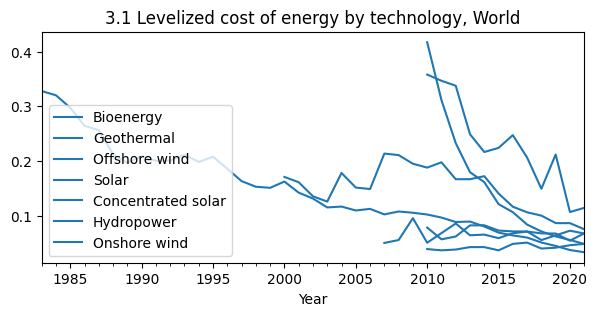

In [12]:
# 3: Best future price for non-fossil fuel energy

energy_cost = pd.read_csv("https://raw.githubusercontent.com/Whyisthisnamenotavailable/final-CO2-assignment/main/levelized-cost-of-energy.csv", index_col='Year',
                          skiprows=lambda x: x not in list(range(448, 487, 1)) + [0],
                          usecols=lambda x: x not in ['Code'])

energy_cost.rename(columns= {'Bioenergy levelized cost of energy': 'Bioenergy',
                             'Geothermal levelized cost of energy': 'Geothermal',
                             'Offshore wind levelized cost of energy': 'Offshore wind',
                             'Solar photovoltaic levelized cost of energy': 'Solar',
                             'Concentrated solar power levelized cost of energy': 'Concentrated solar',
                             'Hydropower levelized cost of energy': 'Hydropower',
                             'Onshore wind levelized cost of energy': 'Onshore wind'}, inplace=True)

energy_cost.index = pd.to_datetime(energy_cost.index, format='%Y').to_period('Y')
energy_cost.sort_index(inplace=True)

energy_cost['Geothermal'].interpolate(method="linear", inplace=True)

energy_cost.plot(style='-',
        figsize=(7, 3),
        color=color_pal[0],
        title='3.1 Levelized cost of energy by technology, World')
plt.show()

------------------------------
3.2 non-stationarity


Energy,Bioenergy,Geothermal,Offshore wind,Solar,Concentrated solar,Hydropower,Onshore wind
p-value,0.863327,0.830764,0.709018,0.863327,0.863327,0.863327,-1.261024


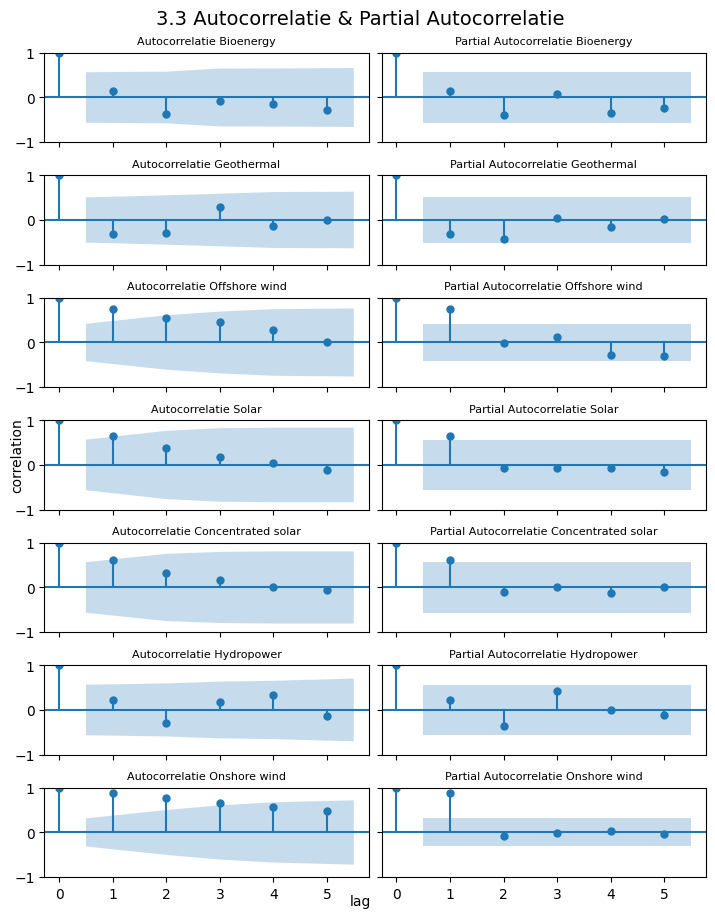

In [13]:
# stationarity

energy_cost.drop(columns=['Entity'], inplace=True)
p_value = []
df_cols = energy_cost.columns.tolist()
for i in df_cols[0:-1]:
  dftest = adfuller(energy_cost[f'{i}'].notnull(), autolag='AIC')
  p_value.append(dftest[1])
dftest_Onshore_wind = adfuller(energy_cost['Onshore wind'], autolag='AIC')
p_value.append(dftest_Onshore_wind[0])

p_value_df = pd.DataFrame(data=p_value, columns=['p-value'], index=range(len(df_cols)))
p_value_df['Energy'] = df_cols
p_value_df.set_index('Energy', drop=True, inplace=True)

print('------------------------------')
print('3.2 non-stationarity')
display(p_value_df.T)

# autocorrelatie

fig, ax = plt.subplots(7,2, figsize=(7,9), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('3.3 Autocorrelatie & Partial Autocorrelatie', fontsize=14)
fig.text(0.5, 0, 'lag', ha='center')
fig.text(0, 0.5, 'correlation', va='center', rotation='vertical')

h = 0
for i in energy_cost.columns.tolist():

  acf = plot_acf(energy_cost.loc[energy_cost[i].notnull(), i], lags=5, ax=ax[h, 0], alpha=.05, title=f'Autocorrelatie {i}')
  ax[h, 0].title.set_size(8)
  pacf = plot_pacf(energy_cost.loc[energy_cost[i].notnull(), i], lags=5, ax=ax[h, 1], title=f'Partial Autocorrelatie {i}')
  ax[h, 1].title.set_size(8)
  h += 1

## fig.savefig('out.png', dpi=100)

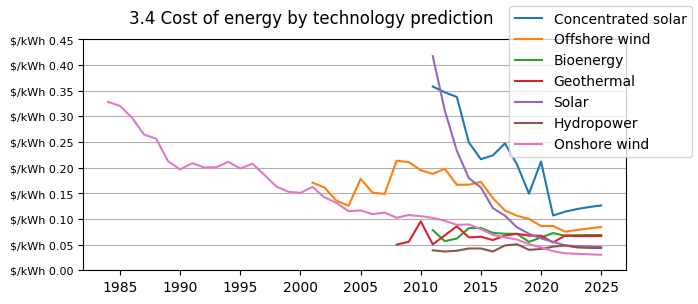

In [14]:
energy_cost_pred_list = []

for i in energy_cost.columns.tolist():
  x = energy_cost[i].dropna().values
  model = AutoReg(x, 1, seasonal=False).fit()
  # print(model.summary())
  pred = model.predict(start=len(x), end=len(x)+2)
  pred_index = pd.date_range(start='2022', periods=3, freq='Y')
  pred_df = pd.DataFrame(data=pred, columns=[i], index=pred_index)
  pred_df.index = pd.to_datetime(pred_df.index, format='%Y').to_period('Y')
  pred_df.index.name = 'Year'
  energy_cost_pred_list.append(pred_df)

energy_cost_pred_axis1 = pd.concat(energy_cost_pred_list, axis=1, ignore_index=False)
energy_cost_pred = pd.concat([energy_cost, energy_cost_pred_axis1])
energy_cost_pred = energy_cost_pred.copy()
energy_cost_pred = energy_cost_pred.sort_values(by='2024', axis=1, ascending=False)

plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize = (7,3))
fig.suptitle('3.4 Cost of energy by technology prediction', x=0.45)

ax.plot(energy_cost_pred.to_timestamp(freq='Y')) #, label=''

ax.set_ylim([0,0.45])
ax.set_yticks(np.linspace(*ax.get_ybound(), 10))
labels = ['$/kWh ' + item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(labels=labels, fontsize=8)

ax.yaxis.grid()

fig.legend(energy_cost_pred.columns.tolist())
plt.show()